<a href="https://colab.research.google.com/github/edmilsonsgjk/fraude_detection/blob/master/ieee_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

In [4]:
os.environ['KAGGLE_USERNAME'] = "XX" 
os.environ['KAGGLE_KEY'] = "XX" 
!kaggle competitions download -c ieee-fraud-detection

 90% 47.0M/52.5M [00:00<00:00, 59.8MB/s]
100% 52.5M/52.5M [00:00<00:00, 133MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 132MB/s]
 65% 31.0M/47.3M [00:00<00:00, 107MB/s] 
100% 47.3M/47.3M [00:00<00:00, 158MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 98.5MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 163MB/s]


In [0]:
from zipfile import ZipFile

zf = ZipFile('train_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('train_identity.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_identity.csv.zip', 'r')
zf.extractall()
zf.close()

In [0]:
train_transection = pd.read_csv('train_transaction.csv', low_memory=False)
train_identity = pd.read_csv('train_identity.csv', low_memory=False)
test_transection = pd.read_csv('test_transaction.csv', low_memory=False)
test_identity = pd.read_csv('test_identity.csv', low_memory=False)

solução para economizar de 60% a 75% do uso de memória em cada dataframe baseado no codigo do link
https://www.kaggle.com/gemartin/load-data-reduce-memory-usage


In [0]:
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
train_transection = reduce_mem_usage(train_transection)
train_identity = reduce_mem_usage(train_identity)
test_transection = reduce_mem_usage(test_transection)
test_identity = reduce_mem_usage(test_identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [0]:
train = pd.merge(train_transection, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transection, test_identity, on = 'TransactionID', how = 'left')

In [12]:
train.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [13]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2636.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
del train_transection, train_identity, test_transection, test_identity

In [0]:
miss_data = pd.isnull(train).sum().sort_values(ascending=False)
miss_per = (miss_data/len(train))*100
missing_data = pd.concat(objs = [miss_data, miss_per], keys = ['Columns','Missing values percentage'], axis = 1)

In [0]:
def delnullcol(dt):
    nullcol = [col for col in dt.columns if dt[col].isnull().sum()/dt.shape[0] >= 0.9]
    return nullcol

In [0]:
rep_vals = [col for col in train.columns if train[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
cols=[]
for col in rep_vals:
    cols.append(train[col].value_counts(dropna = False).values[0])

In [0]:
def repcols(dt):
    rep_vals = [col for col in dt.columns if dt[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
    return rep_vals

In [0]:
def useless_cols(dt, exep):
    null_cols = delnullcol(dt)
    print("More than 90% null: " + str(len(null_cols)))
    too_many_repeated = repcols(dt)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(null_cols + too_many_repeated))
    cols_to_drop.remove(exep)
    return cols_to_drop

In [24]:
cols_to_drop = useless_cols(train, 'isFraud')

More than 90% null: 12
More than 90% repeated value: 67


In [0]:
def find_Major_values(dt, threshold):
    Major_values = []
    t=dt.value_counts(dropna = True, normalize = True)
    for i in range(len(t)):
        if t.values[i] >= threshold:
            Major_values.append(t.values[i])
    return Major_values

In [0]:
def find_Major_Devices(Major_values,dt):
    Major_Devices = []
    t = dt.value_counts(dropna = True, normalize = True)
    for i in Major_values:
        for j in t.items():
            if j[1] == i:
                Major_Devices.append(j[0])
    return Major_Devices

In [0]:
def find_plot(Major_Devices,d,dt):
    plothis=[]
    for i in range(len(Major_Devices)):
        plothis.append(d.loc[dt == Major_Devices[i]])
    if len(plothis) == 0:
        return 10
    else:
        plothis = pd.concat(objs = [i for i in plothis], axis = 0)
        return plothis

visualização


In [0]:
sns.set(style = "whitegrid")

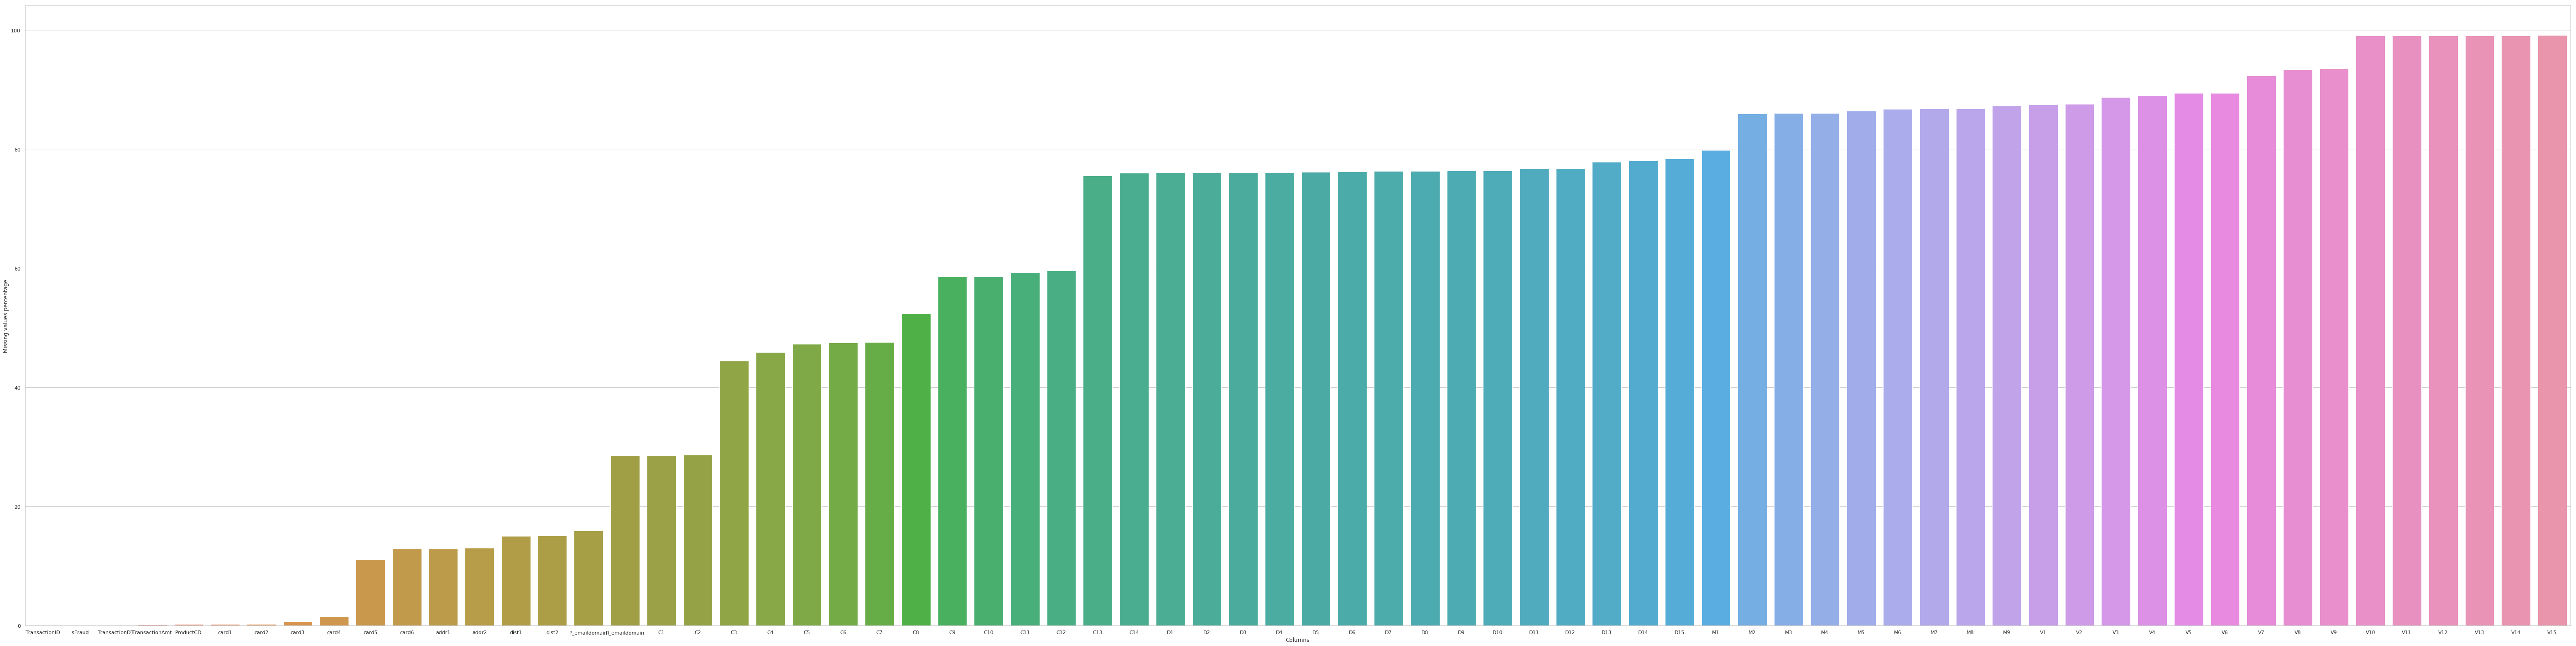

In [30]:
plt.figure(figsize=(100,25))
p = sns.barplot(x = 'Columns', y = 'Missing values percentage', data = missing_data)
p.set_xticklabels(list(train.columns))
p

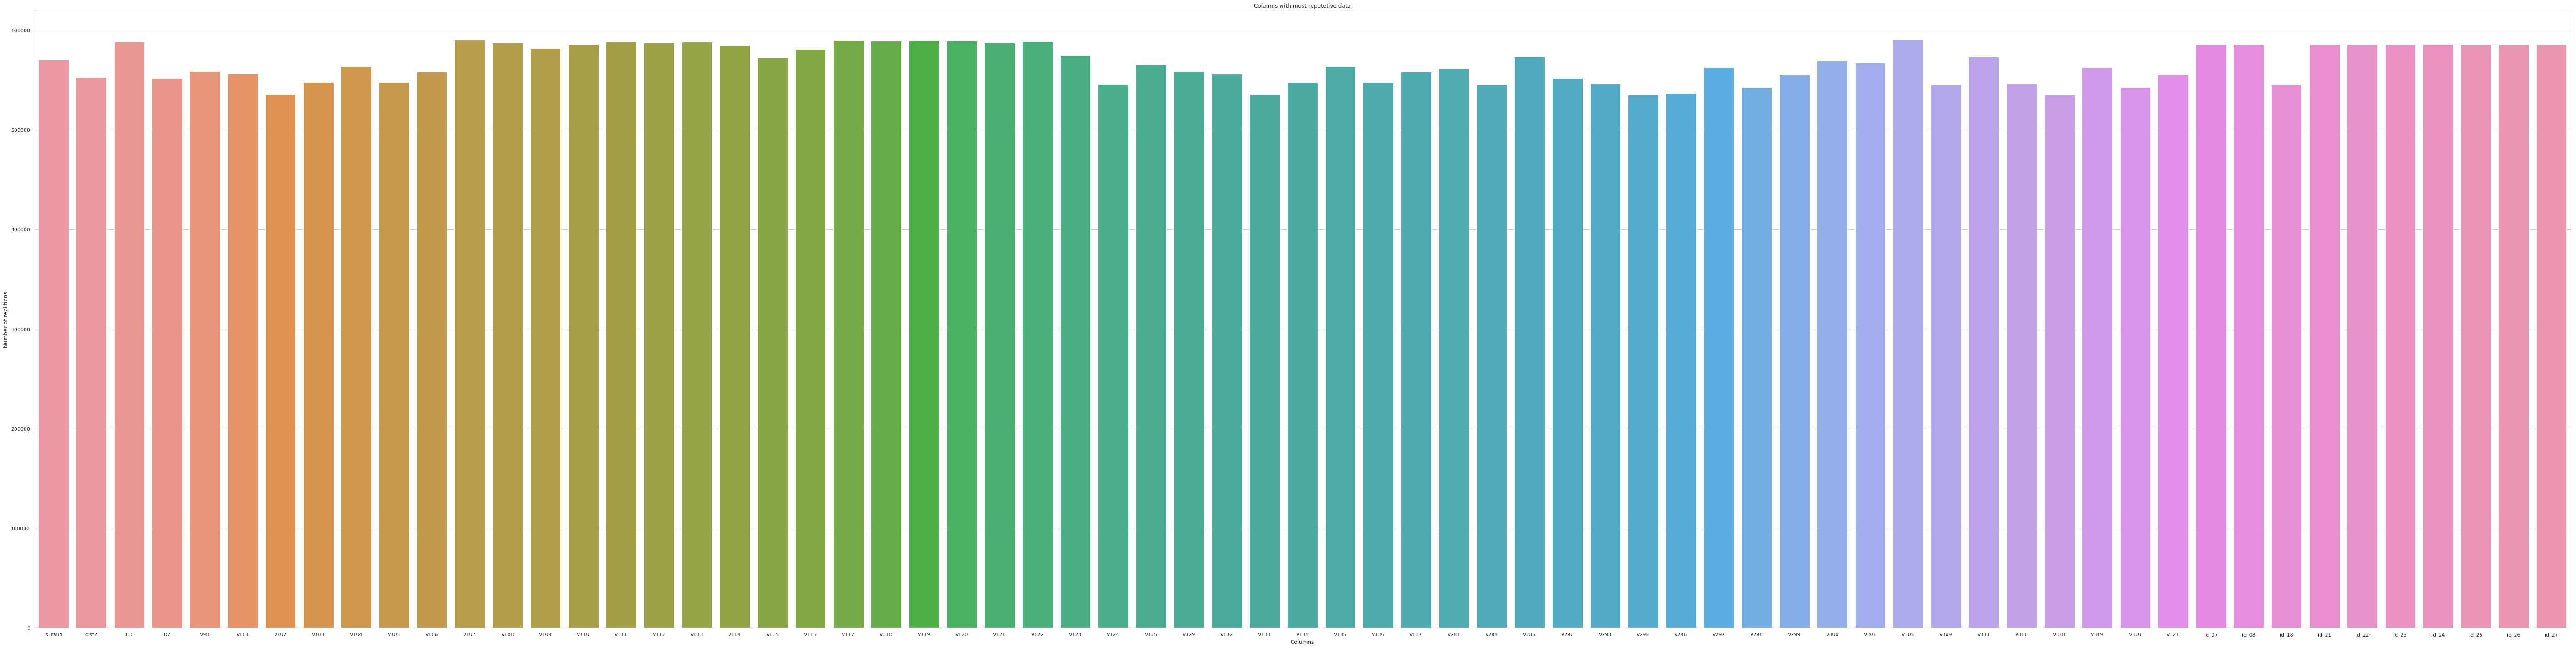

In [31]:
plt.figure(figsize=(100,25))
p2 = sns.barplot(x = rep_vals, y = cols)
plt.title("Columns with most repetetive data")
p2.set(xlabel='Columns', ylabel='Number of replitions')
p2

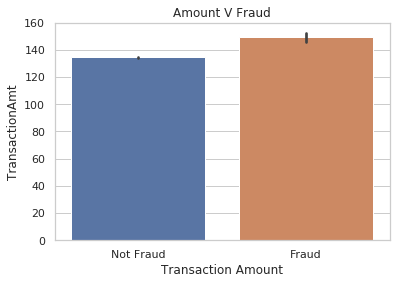

In [33]:
amnt = sns.barplot(x = train['isFraud'], y = train['TransactionAmt'], data = train)
plt.title("Amount V Fraud")
amnt.set_xticklabels(['Not Fraud','Fraud'])
amnt.set(xlabel='Transaction Amount')
amnt

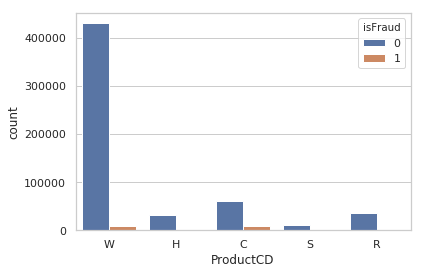

In [34]:
sns.countplot(train['ProductCD'], hue='isFraud', data=train)


<Figure size 864x360 with 0 Axes>

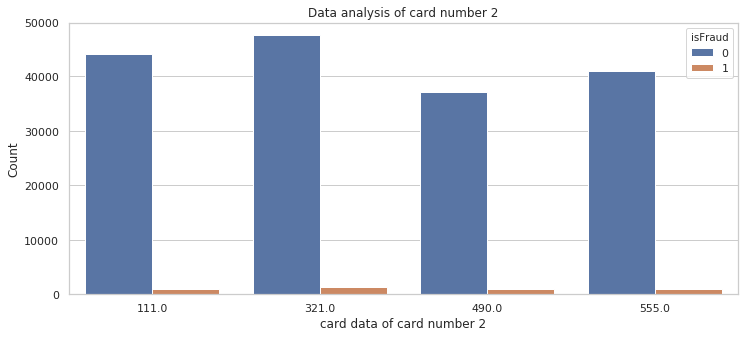

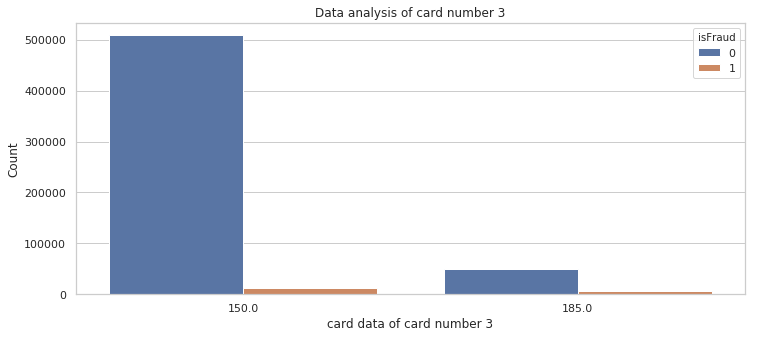

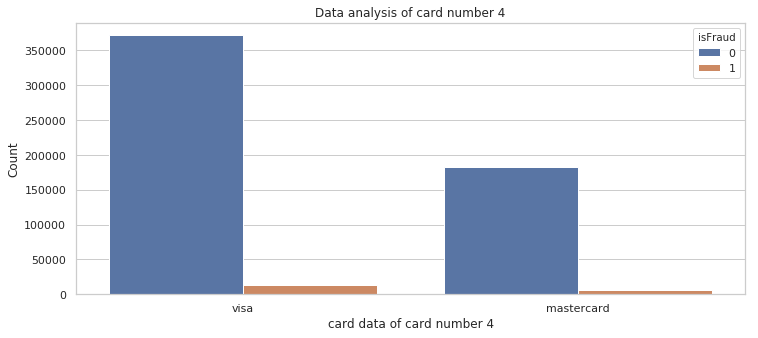

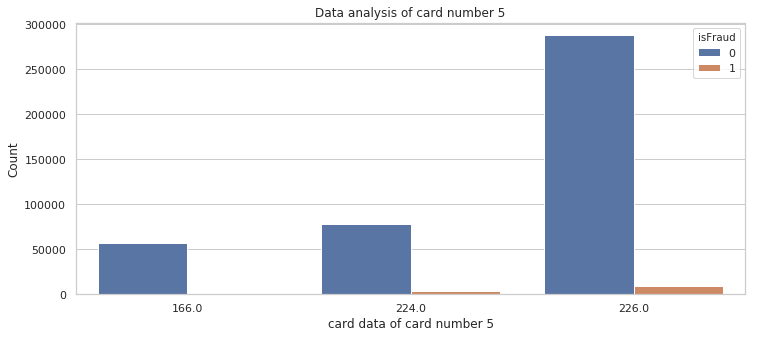

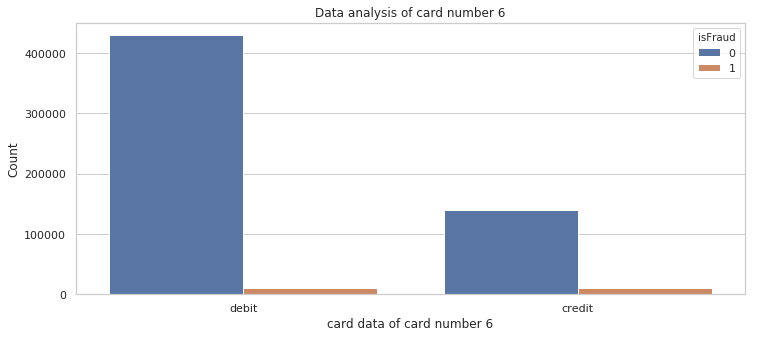

In [35]:
for i in range(1,7):
    mv1 = find_Major_values(train['card'+str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['card'+str(i)])
    plothis1 = find_plot(md1, train, train['card'+str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['card'+str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of card number "+str(i))
        p4.set(xlabel='card data of card number '+str(i), ylabel='Count')
        p4

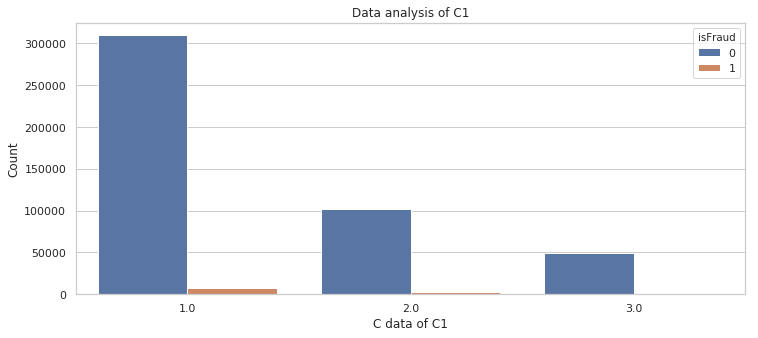

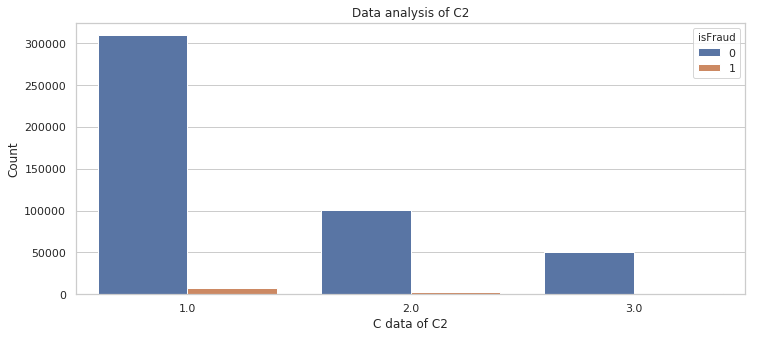

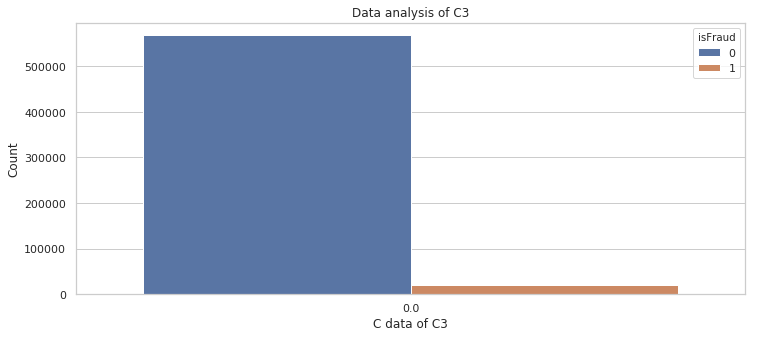

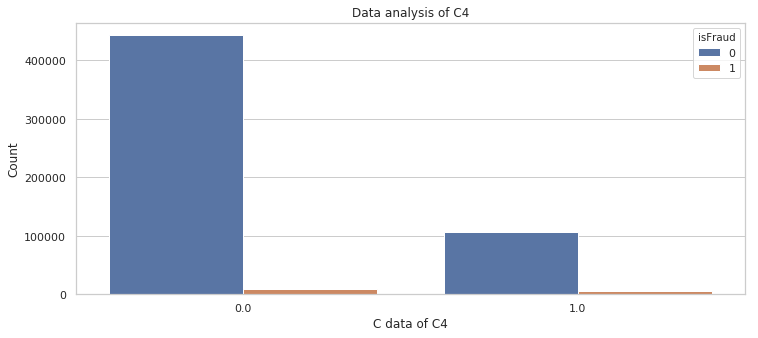

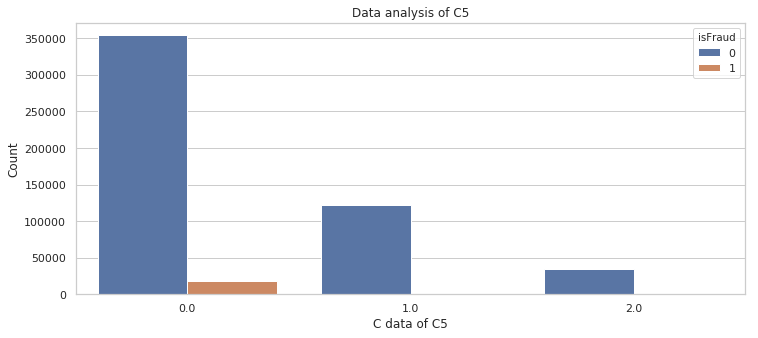

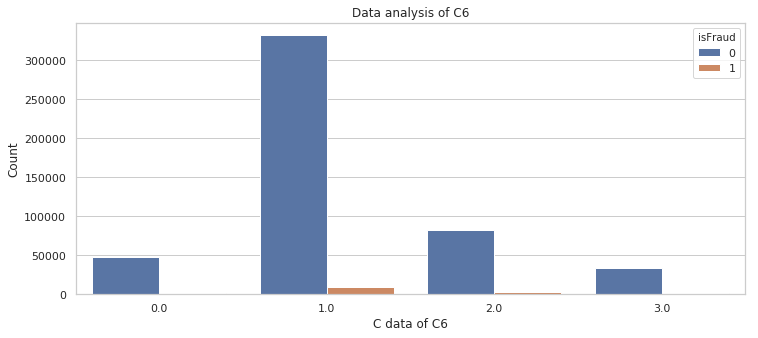

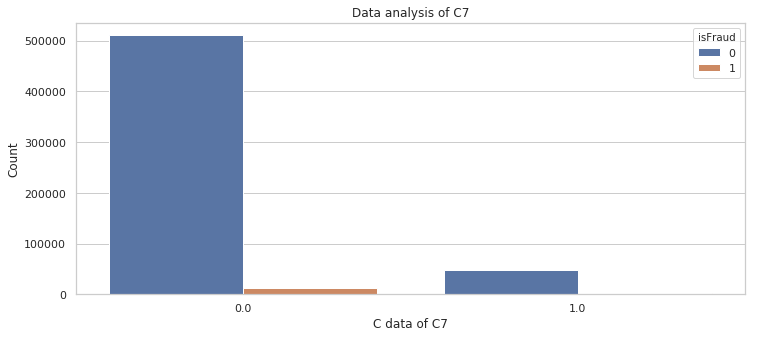

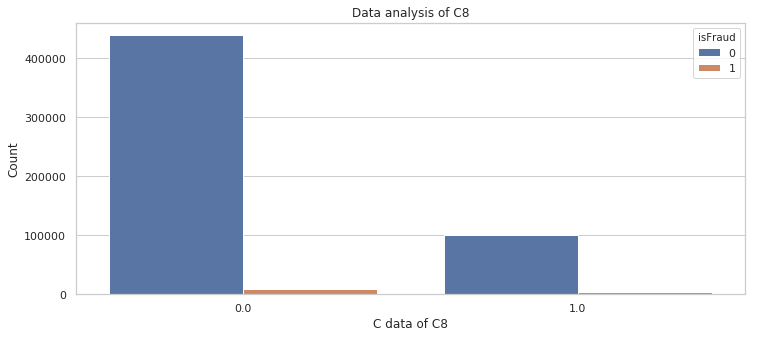

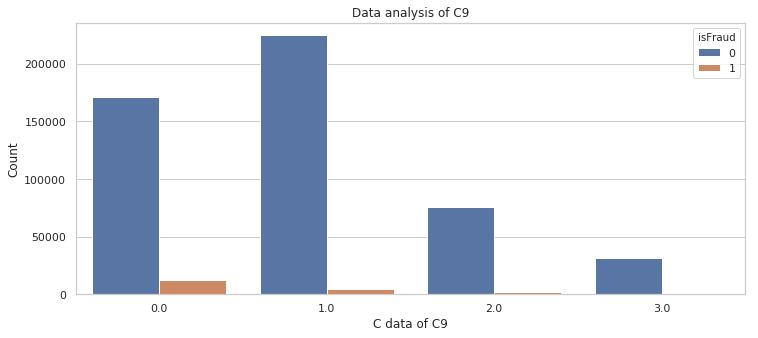

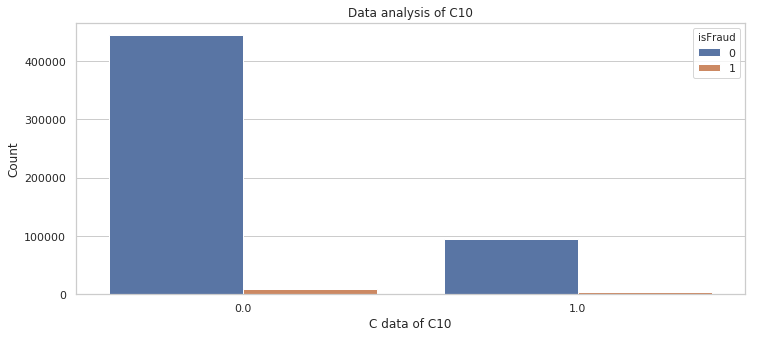

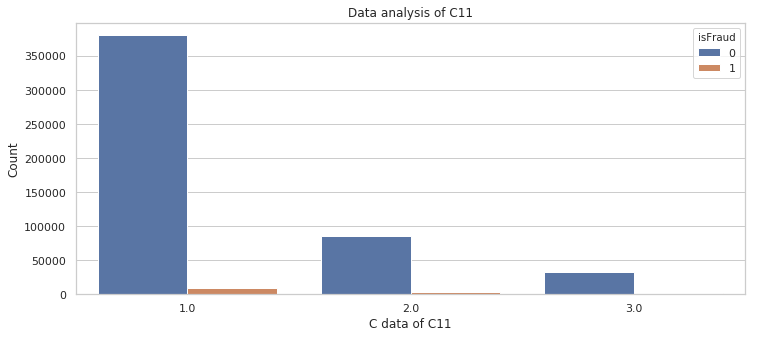

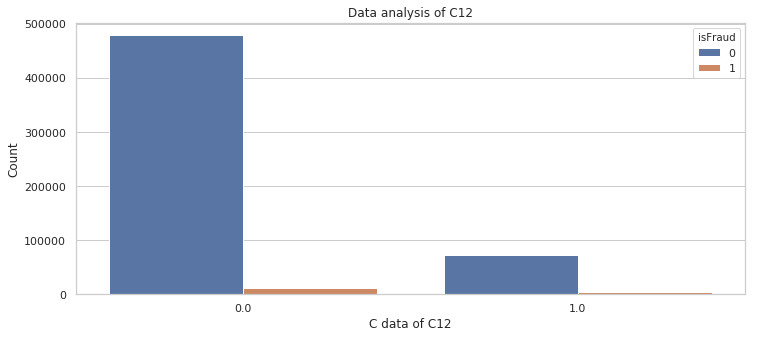

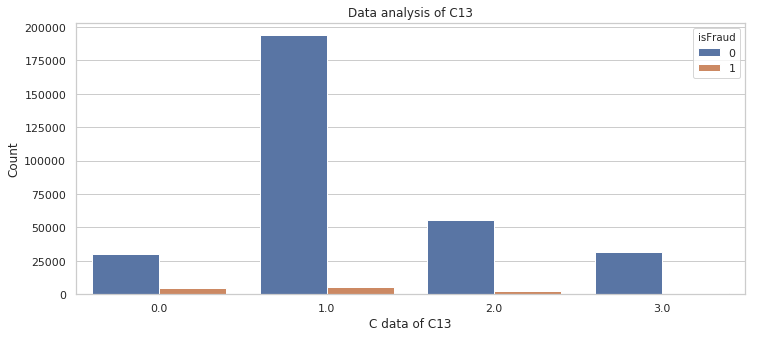

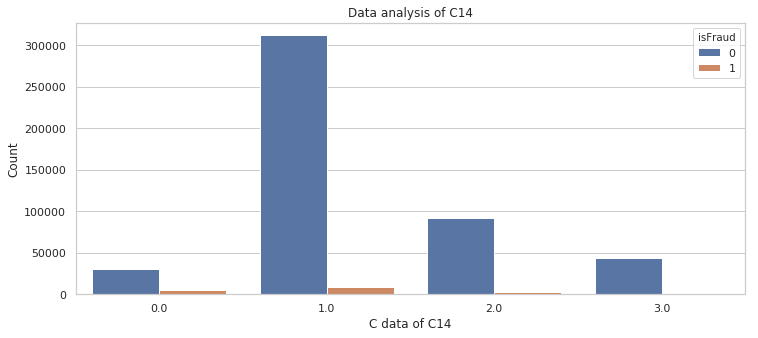

In [36]:
for i in range(1, 15):
    mv1 = find_Major_values(train['C' + str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['C' + str(i)])
    plothis1 = find_plot(md1, train, train['C' + str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['C' + str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of C" + str(i))
        p4.set(xlabel='C data of C' + str(i), ylabel='Count')
        p4